# Models in PyTorch and Training Pipeline

In [1]:
# Some imports

# computation stuff
import torch
import numpy as np

# plotting stuff
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina' # makes the quality higher

import seaborn as sns
sns.set_style("whitegrid") # improves the quality of matplotlib images and adds grid

# Model Creation

In PyTorch, all models are instances of the class `torch.nn.Module`. To create your model, all you need is to

1. Define network layers
2. Define forward step: `forward` method of the class (it works as `__call__` method, but conventionally we always use `forward` method)

Note that **backward step is defined automatically** by `PyTorch` itself. However, in rare cases, when you apply a complicated custom layer, which require some custom backward step, you can also define this step yourself. 

The most popular layers are pre-defined in `torch.nn.Module` (see [documentation](https://pytorch.org/docs/stable/nn.html)):

* Linear layer (a.k.a. Fully-Connected Layer): `nn.Linear`
* Convolutional layer: `nn.Conv1d`, `nn.Conv2d`, `nn.Conv3d`
* Max-pooling layer: `nn.MaxPool1d`, `nn.MaxPool2d`, `nn.MaxPool3d`
* Average-pooling layer: `nn.AvgPool1d`, `nn.AvgPool2d`, `nn.AvgPool3d`
* And many more

Thus, to define our model, we will create a subclass of `torch.nn.Module`, define layers and `forward` step:

In [14]:
from torch import nn

In [3]:
class MyModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        # initialize everything from the root class
        # PyTorch won't allow you to define variable using nn.LayerName before this call
        super().__init__()

        self.net1 = nn.Linear(input_size, hidden_size)
        self.net2 = nn.ReLU()
        self.net3 = nn.Linear(hidden_size, hidden_size)
        self.net4 = nn.ReLU()
        self.net5 = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_data):
        x = self.net1(input_data)
        x = self.net2(x)
        x = self.net3(x)
        x = self.net4(x)
        output = self.net5(x)
        return output

Now we can create an instance of our class and run it

In [5]:
model = MyModel(10, 128, 2)
print(model)

MyModel(
  (net1): Linear(in_features=10, out_features=128, bias=True)
  (net2): ReLU()
  (net3): Linear(in_features=128, out_features=128, bias=True)
  (net4): ReLU()
  (net5): Linear(in_features=128, out_features=2, bias=True)
)


In [8]:
example_tensor = torch.randn(10)
model(example_tensor) # equivalent to model.forward(example_tensor)

tensor([-0.0381,  0.0912], grad_fn=<ViewBackward0>)

Note that we applied each `netN` one after another. In such a case, creating several variables makes the code more complicated. `PyTorch` has a special class `nn.Sequential` designed for sequential application of several layers.

Depending on your architecture, you may also find [nn.ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) and [nn.ModuleDict](https://pytorch.org/docs/stable/generated/torch.nn.ModuleDict.html) useful. 

Let's rewrite our model:

In [13]:
class MyModelSequential(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()      

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, input_data):
        return self.net(input_data) # sequential saved us a lot of space

model = MyModelSequential(10, 128, 2)
print(model)

MyModelSequential(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [14]:
model(example_tensor)

tensor([-0.0041,  0.1142], grad_fn=<ViewBackward0>)

**Important** is is not mandatory to write everything in one class, you can split your model in several classes and then join them in the main class: 

In [20]:
class MyCustomLayer(nn.Module):
    
    def __init__(self, in_hidden, out_hidden):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_hidden, out_hidden),
            nn.ReLU()
        )

    def forward(self, input_data):
        return self.layer(input_data)


class MyModelCustomLayer(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()      

        self.net = nn.Sequential(
            MyCustomLayer(input_size, hidden_size),
            MyCustomLayer(hidden_size, hidden_size),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, input_data):
        return self.net(input_data)

model = MyModelCustomLayer(10, 128, 2)
print(model)

MyModelCustomLayer(
  (net): Sequential(
    (0): MyCustomLayer(
      (layer): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): ReLU()
      )
    )
    (1): MyCustomLayer(
      (layer): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
    )
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [21]:
model(example_tensor)

tensor([ 0.0519, -0.0400], grad_fn=<ViewBackward0>)

Note that model weights are **initialized randomly**:

In [22]:
model = MyModel(10, 128, 2)
print(model(example_tensor))

model = MyModel(10, 128, 2)
print(model(example_tensor))

tensor([ 0.0245, -0.2604], grad_fn=<ViewBackward0>)
tensor([-0.1984, -0.0829], grad_fn=<ViewBackward0>)


Even though we used the same input, the result is different (this is also the reason why three equivalent versions of our model resulted in different outputs). **Do not forget about randomness if you want to make your results reproducible**. *We will talk more about this in the next seminar*

Usually `PyTorch` initialization scheme is enough. Sometimes you may want to do custom initialization, we won't cover how do it in details during this seminar. However, **never** use constant initialization, unless you know what you are doing, because this may ruin utilization of neuron difference within the layer.

Just to show that 3 versions of model are equivalent, we will set all their weights to the same ones. We will set them to constant value for the simplicity of the example.

In [37]:
model = MyModel(10, 128, 2)
model_seq = MyModelSequential(10, 128, 2)
model_custom = MyModelCustomLayer(10, 128, 2)

In [38]:
def set_weights_with_ones(model):
    for module in model.modules(): # use named_modules() if you want to get module name like `net` or `net.0`
        # for cycle over all models inside our model
        if isinstance(module, nn.Linear):
            module.weight.data = torch.ones_like(module.weight.data)
            module.bias.data = torch.ones_like(module.bias.data)

In [39]:
set_weights_with_ones(model)
set_weights_with_ones(model_seq)
set_weights_with_ones(model_custom)

In [40]:
print(model(example_tensor))
print(model_seq(example_tensor))
print(model_custom(example_tensor))

tensor([17452.8613, 17452.8613], grad_fn=<ViewBackward0>)
tensor([17452.8613, 17452.8613], grad_fn=<ViewBackward0>)
tensor([17452.8613, 17452.8613], grad_fn=<ViewBackward0>)


Note that because of the constant value, there is no difference between `output[0]` and `output[1]`. This is the problem

# Optimization (Training a model, finding local minima, etc.)

Let's recall optimization example from the previous seminar:

In [2]:
def func(x):
    return (x - 10) ** 2 + 14

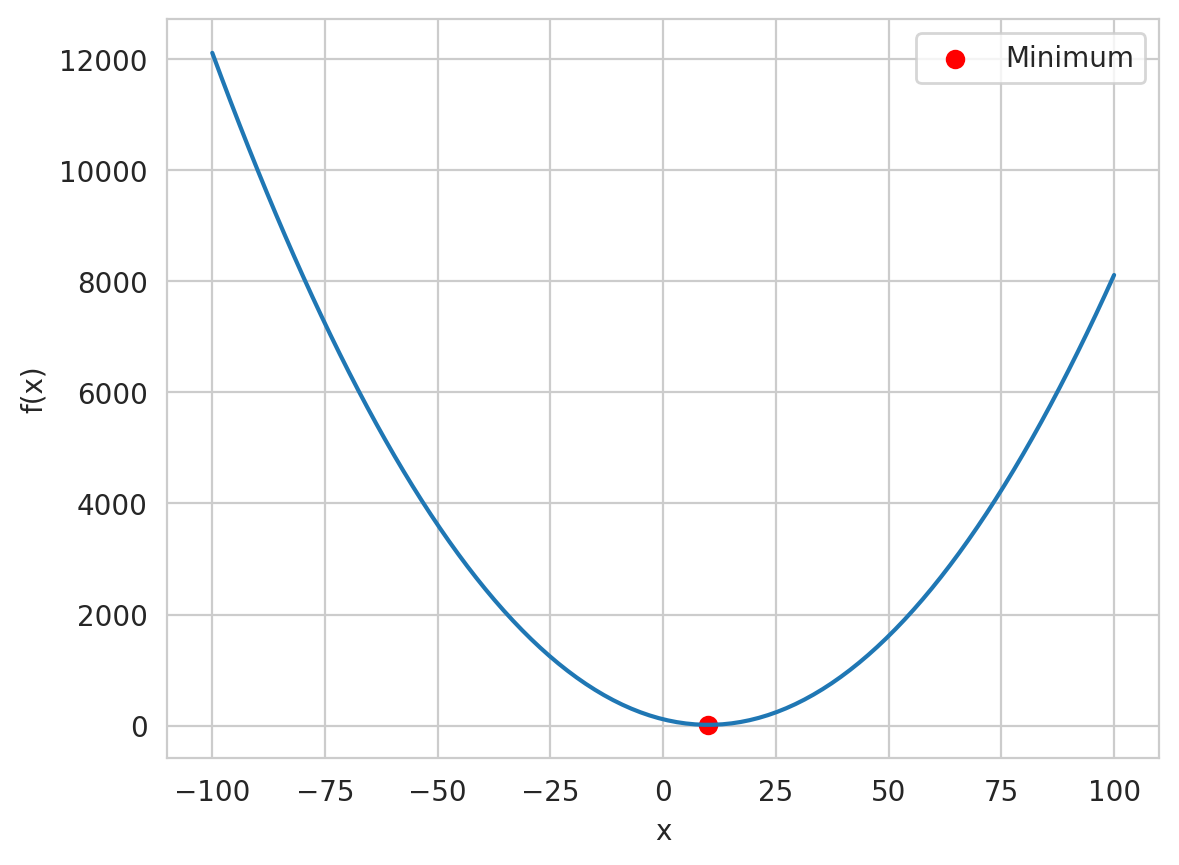

In [3]:
x = torch.linspace(-100, 100, 100)
y = func(x)

plt.plot(x, y)
plt.scatter([10], [14], label='Minimum', c='red')
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [4]:
import time
from IPython import display

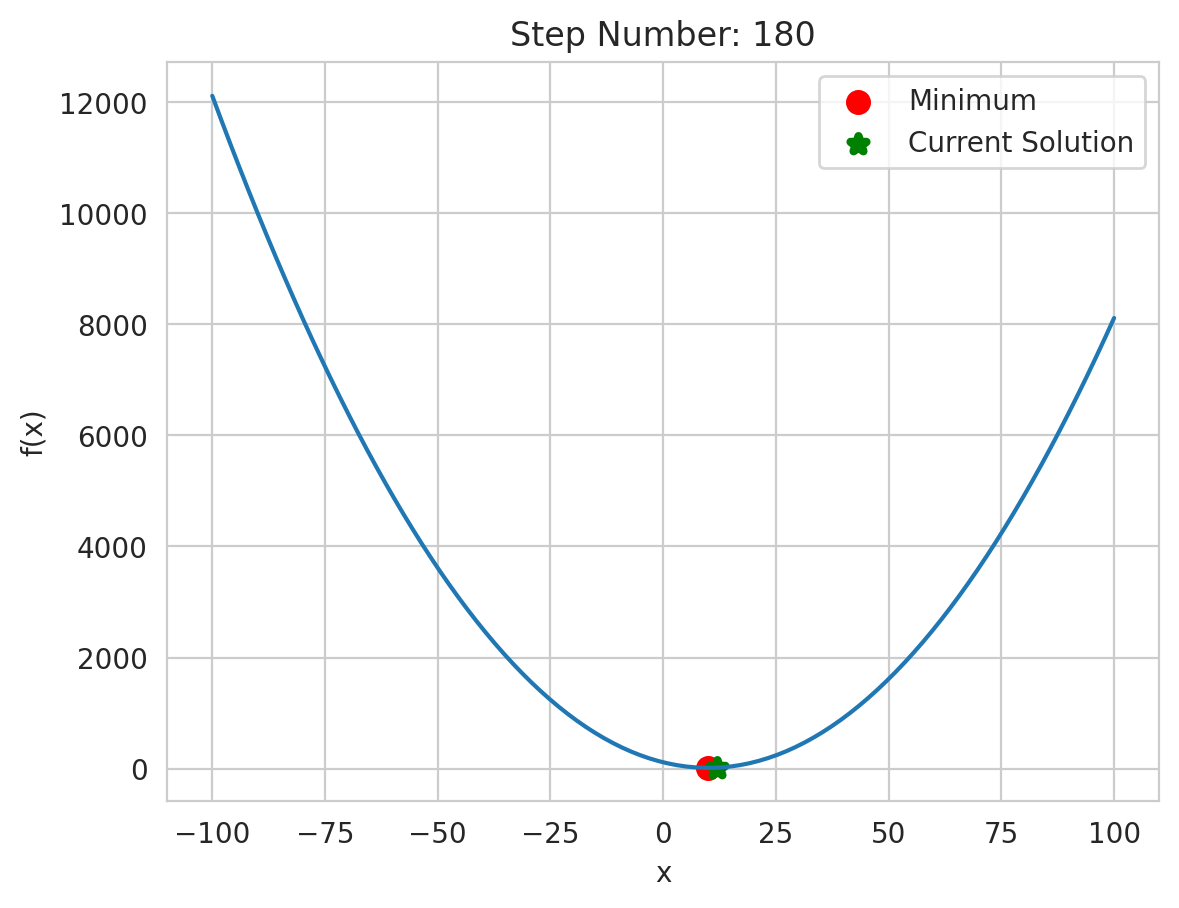

In [11]:
# requires_grad=True is required
# this is our starting point
current_solution = torch.randint(low=-100, high=100, size=(1,), dtype=torch.float32, requires_grad=True)

# initialize a simple SGD
# SGD will minimize only one variable — current_solution
optimizer = torch.optim.SGD([current_solution], lr=1e-2)

NUM_STEP = 200


for i in range(NUM_STEP):
    current_loss = func(current_solution)
    
    # zero out .grad of `current_solution` 
    # remember that otherwise your new gradients will be summed with the existing ones
    optimizer.zero_grad()
    
    # compute new gradient by `current_solution`
    current_loss.backward()
    
    # update current_solution
    optimizer.step()

    # some logging and visualization stuff
    if i % 20 == 0:
        display.clear_output()
        
        x = torch.linspace(-100, 100, 100)
        y = func(x)

        plt.plot(x, y)
        plt.scatter([10], [14], label="Minimum", c="red", linewidths=3)
        plt.scatter([current_solution.item()], [current_loss.item()],
                    label="Current Solution", marker="*", c="green", linewidths=3)
        
        plt.legend()
        plt.title(f"Step Number: {i}")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.show()
        
        time.sleep(1)

## DNN Training pipeline

Training pipeline for your DNN model is similar to the example with some function above. To train your model you will need:

1. Define your model
2. Define a `Dataset` and `DataLoader`. Make sure you have at least 2 splits: train\test, so you can monitor performance on unseen data
3. Choose an optimizer. We advise you to use `torch.optim.Adam` or `torch.optim.AdamW` (if you use weight decay). Your optimizer should work with `model.parameters()` to optimize model weights. Basically, we will have `model.parameters()` instead of `[current_solution]` in the example above.
4. Choose a scheduler. That is, control learning rate (step size) for your optimizer. There are plenty of them in `torch.optim.lr_scheduler`. We advise you to use [CosineAnnealing](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR) or [OneCycleLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR). The latter uses warm-up technique (the learning rate goes from low value to high during the first several steps and then the scheduler decreases the learning rate as usual), which is essential for Transformer-based models. The absence of scheduler is equivalent to a constant learning rate.
5. Iterate over your dataloader (for DNNs you reuse the same dataloader (the data shuffles) several times, a.k.a. epochs). For each batch, compute the loss, do `.backward`, run `optimizer.step()` to update weights and `scheduler.step()` to update learning rate. **Do not forget to zero gradients between batches via calling `oprimizer.zero_grad()` after `step()` or at the beginning of the for-loop**. Do some logging (recommended).
6. Finish, your model is trained.

The choice of the scheduler and optimizer depends on the task. There is no such setting that works all the time, you should try several settings and choose the one that works best for your task. However, usually `Adam`, `AdamW` and one of the mentioned schedulers should do the work (You may need to tune `learning_rate` and `weight_decay`. Do not forget to think about the total number of training steps)

If you want to work with a model from some paper, the best starting point would be to use the **same** optimizer and scheduler (with the **same** hyperparameters, i.e., learning rate, weight decay, etc.), as was done by the authors. However, if the paper is rather **old** and do not use Adam\AdamW (or at least SGD), it is better to use our **suggested** schedulers and optimizers instead (unless you are sure what and why you are doing). The exception is the case when you want to **exactly reproduce** the results from the paper. In such a case, you must use the paper authors' setting to get the authors results.

### Datasets (Train \ Test Split)

Many existing datasets already have standardized train\test splits. However, if your dataset does not have partitioning, you can create it yourself by choosing random subset of the full set as training partition and the rest as testing partition. 

In [2]:
from torch.utils.data import DataLoader, Dataset

#### Transforms

Last time we discussed how to create custom dataset classes. Notice that you can pre-process your data somehow in `__getitem__`. To do this, you can call custom functions on the objects inside `__getitem__`. One popular way to do this is to define `transform` object (object with `__call__` method) or function that will transform your data:

In [3]:
class SimpleDataset(Dataset):
    
    def __init__(self, data: torch.Tensor, transform=None):
        self.data = data
        self.transform=transform
    
    def __getitem__(self, index: int):
        x =  self.data[index]
          
        # you can use class method
        x = self.preprocess(x)

        # or you can use transform (or both)
        if self.transform is not None:
            x = self.transform(x)
        
        return x

    def preprocess(self, x):
        # example
        return x - 300

    def __len__(self):
        return len(self.data)

In [4]:
example_data = torch.randn(1000, 10) # X = 1000 elements (vectors) of size 10
simple_dataset = SimpleDataset(example_data)
simple_dataset[0]

tensor([-300.8042, -301.4843, -297.5219, -299.5457, -300.6189, -298.6737,
        -300.4720, -301.4953, -301.1530, -299.9027])

In [5]:
def double_the_value(x):
    return 2 * x

transform = double_the_value

simple_dataset = SimpleDataset(example_data, transform=transform)
simple_dataset[0]

tensor([-601.6083, -602.9687, -595.0438, -599.0915, -601.2377, -597.3474,
        -600.9440, -602.9907, -602.3061, -599.8054])

#### MNIST

Today, we will use [MNIST dataset](http://yann.lecun.com/exdb/mnist/). This dataset is so popular that you can download it directly from `PyTorch` (from sub-library `torchvision`, which is used for computer vision tasks, to be precise). The task is to identify which number from 0 to 9 is depicted on the image (classification task).

In [6]:
import torchvision

In [7]:
transform = torchvision.transforms.Compose( # Sequential application of transforms, for this example it is unnecessarily
    [
        torchvision.transforms.ToTensor(), # from Image class to Tensor
    ]
)

In [8]:
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=transform
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=transform
)

torch.Size([1, 28, 28])


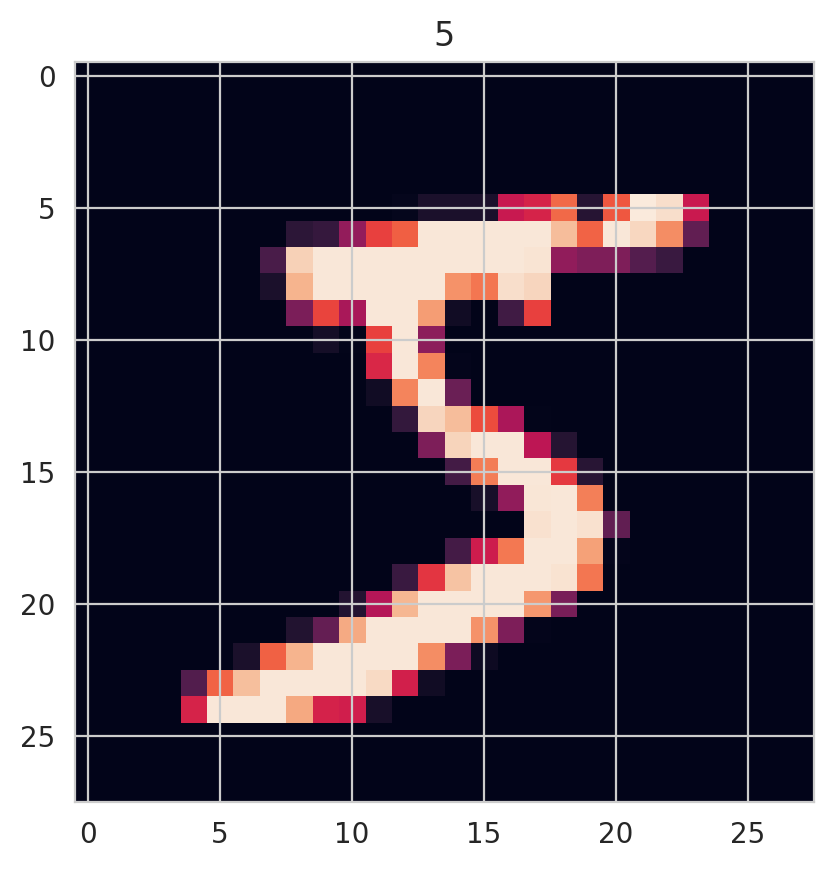

In [9]:
example_img, example_label = mnist_train[0]
print(example_img.shape) # C x H x W, 1 channel -- grayscale image
plt.imshow(example_img[0])
plt.title(example_label)
plt.show()

In [10]:
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=128, shuffle=False)

Dataloader contains `len(dataset) // batch_size`. If `len(dataset) % batch_size != 0`, dataloader skips the rest of the elements unless you set `drop_last=False` (otherwise, you will have 1 more batch with `len(dataset) % batch_size` elements).

In [11]:
print("Train Dataloader length:", len(train_dataloader))
print("Train Dataset length:", len(mnist_train))
print(len(mnist_train) // 128) # != len(train_dataloader) because drop_last=False
print(len(mnist_train) % 128) # there will be one batch of such size instead of 128

Train Dataloader length: 469
Train Dataset length: 60000
468
96


### Model

We will show 3 model examples:

1. Fully-connected network (a.k.a. Multi-layer Perceptron (MLP))
2. Convolutional network
3. Convolutional network with ResBlocks

In [18]:
class FCNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()      

        self.net = nn.Sequential(
            nn.Flatten(), # reshape input from C x H x W to 1D-vector
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [72]:
class ConvNetwork(nn.Module):
    
    def __init__(self, input_channels, hidden_channels, output_size, image_sizes):
        super().__init__()      

        self.net = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(), # to do classification we flatten
            # you need to calculate the flatten size
            nn.Linear(hidden_channels * image_sizes[0] * image_sizes[1], output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [20]:
class ResBlock(nn.Module):

    def __init__(self, input_channels, hidden_channels):
        super().__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
        )

        self.downsample = None
        if input_channels != hidden_channels:
            self.downsample_conv = nn.Conv2d(input_channels, hidden_channels, kernel_size=1)

    def forward(self, x):
        output = self.convs(x)
        if self.downsample is not None:
            # sometimes output + x won't work due to shape mismatch
            # for example if height and width does not match
            # or if channels does not match (if we have only single channel it will work though, but in general won't)
            x = self.downsample(x)
        return output + x # residual connection


class ResNetwork(nn.Module):
    
    def __init__(self, input_channels, hidden_channels, output_size, image_sizes):
        super().__init__()      

        self.net = nn.Sequential(
            ResBlock(input_channels, hidden_channels),
            ResBlock(hidden_channels, hidden_channels),
            nn.Flatten(), # to do classification we flatten
            # you need to calculate the flatten size
            nn.Linear(hidden_channels * image_sizes[0] * image_sizes[1], output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [100]:
fc_net = FCNetwork(example_img.flatten().shape[0], 128, 10) # 10 labels
print(fc_net)

FCNetwork(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [101]:
conv_net = ConvNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
print(conv_net)

ConvNetwork(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=25088, out_features=10, bias=True)
  )
)


In [102]:
res_net = ResNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
print(res_net)

ResNetwork(
  (net): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (downsample_conv): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ResBlock(
      (convs): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=25088, out_features=10, bias=True)
  )
)


### Loss function

We should define loss function to train our model. As we do classification, the good idea would be to use [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). 

Note that we should pass the **predicted** probabilities for each class and target class label. To get probabilities from raw scores, we should use `softmax` function `probas = torch.nn.functional.softmax(model_output, dim=-1)`. But `CrossEntropyLoss` does it automatically, so we can skip this softmax and return raw scores.

In [103]:
criterion = nn.CrossEntropyLoss()

### Training pipeline

In [104]:
from IPython import display

[tqdm](https://github.com/tqdm/tqdm) is a useful tool that allows to see the progress bar.

In [105]:
from tqdm.auto import tqdm

In [130]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to train mode during training
    model.train()

    avg_loss = 0
    for batch_idx, (image, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device 
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        loss.backward() # calculate gradients
        optimizer.step() # update weights
        optimizer.zero_grad() # zero gradients for the next step
        scheduler.step() # update learning rate

        avg_loss += loss.item() # item to detach loss and get element on CPU
        # item is used for tensors containing single scalar

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    return avg_loss


def evaluate(model, dataloader, criterion, device):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to eval mode during inference
    model.eval()

    avg_loss = 0
    accuracy = 0
    total_elements = 0
    for batch_idx, (image, label) in enumerate(dataloader):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device 
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        # you should also calculate some metrics, like accuracy
        accuracy += (output.argmax(-1) == label).sum().item()
        total_elements += output.shape[0] # we will use it to calculate accuracy
        avg_loss += loss.item()

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    accuracy = 100 * accuracy / total_elements
    return avg_loss, accuracy


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, n_epochs):

    train_avg_losses = []
    val_avg_losses = []
    val_accuracy_list = []
    for epoch in range(n_epochs):        
        train_avg_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, scheduler, device)
        val_avg_loss, val_accuracy = evaluate(model, val_dataloader, criterion, device)

        # some logging
                
        # clear output so to redraw the plot
        display.clear_output(wait=True)

        train_avg_losses.append(train_avg_loss)
        val_avg_losses.append(val_avg_loss)
        val_accuracy_list.append(val_accuracy)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].plot(train_avg_losses, color="blue", label="train")
        axes[0].plot(val_avg_losses, color="red", label="val")
        axes[0].set_xlabel("Epoch number")
        axes[0].set_ylabel("Loss")
        axes[0].set_title(f"Min train loss: {round(min(train_avg_losses), 5)}, min val loss: {round(min(val_avg_losses), 5)}")

        axes[1].plot(val_accuracy_list, color="red", label="val")
        axes[1].set_xlabel("Epoch number")
        axes[1].set_ylabel("Accuracy (%)")
        axes[1].set_title(f"Best Accuracy (%): {max(val_accuracy_list)}")
        
        plt.legend()
        plt.tight_layout()
        plt.show()

In [131]:
device = "cuda" if torch.cuda.is_available() else "cpu" # "cuda" -- use GPU, "cpu" -- use CPU
print(device)

cuda


In [132]:
NUM_EPOCHS = 10

### Let's run it

Note that scheduler can be applied each epoch or each step, depending on your wish. We apply it every step. So the total number of scheduler steps will be `NUM_EPOCHS * len(train_dataloader)`

In [133]:
# FC net

# do not forget to put the model itself on device
fc_net = FCNetwork(example_img.flatten().shape[0], 128, 10) # 10 labels
fc_net.to(device)

# define optimizer and scheduler to update weights and learning rate, respectively
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

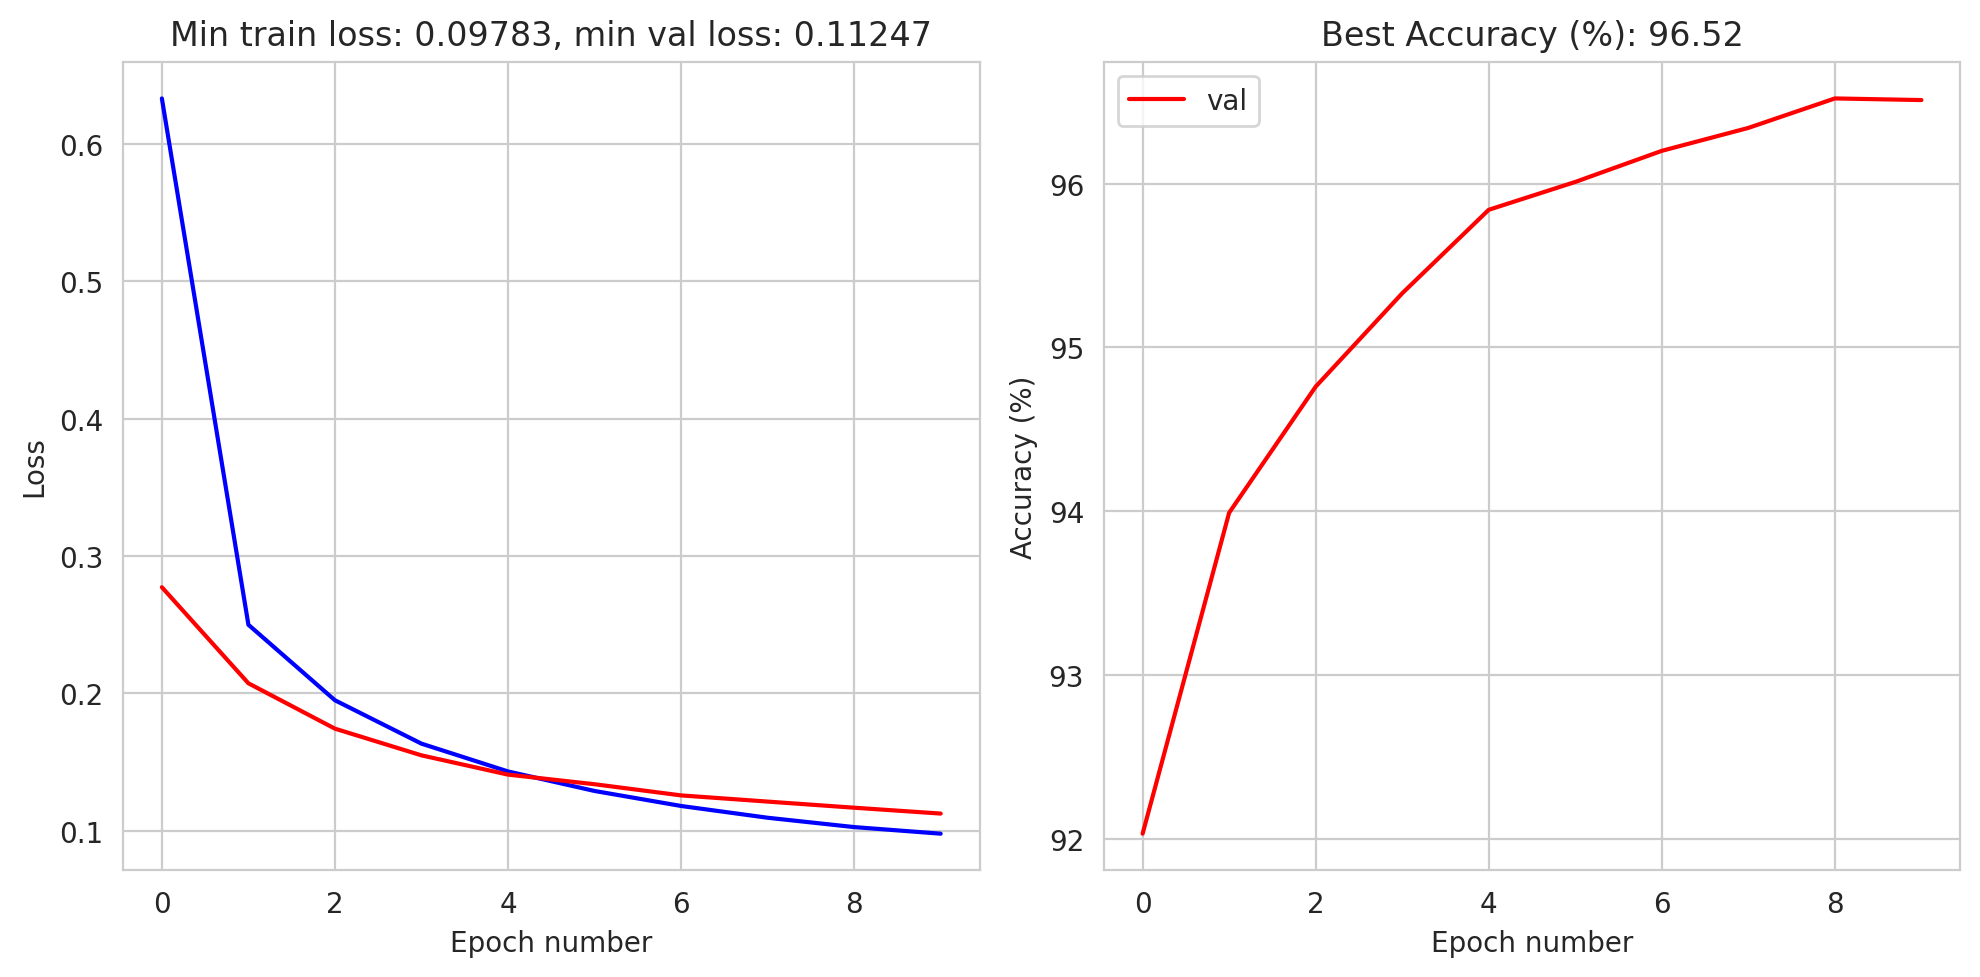

In [134]:
train(fc_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

In [135]:
# Conv net

# do not forget to put the model itself on device
conv_net = ConvNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
conv_net.to(device)

optimizer = torch.optim.Adam(conv_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

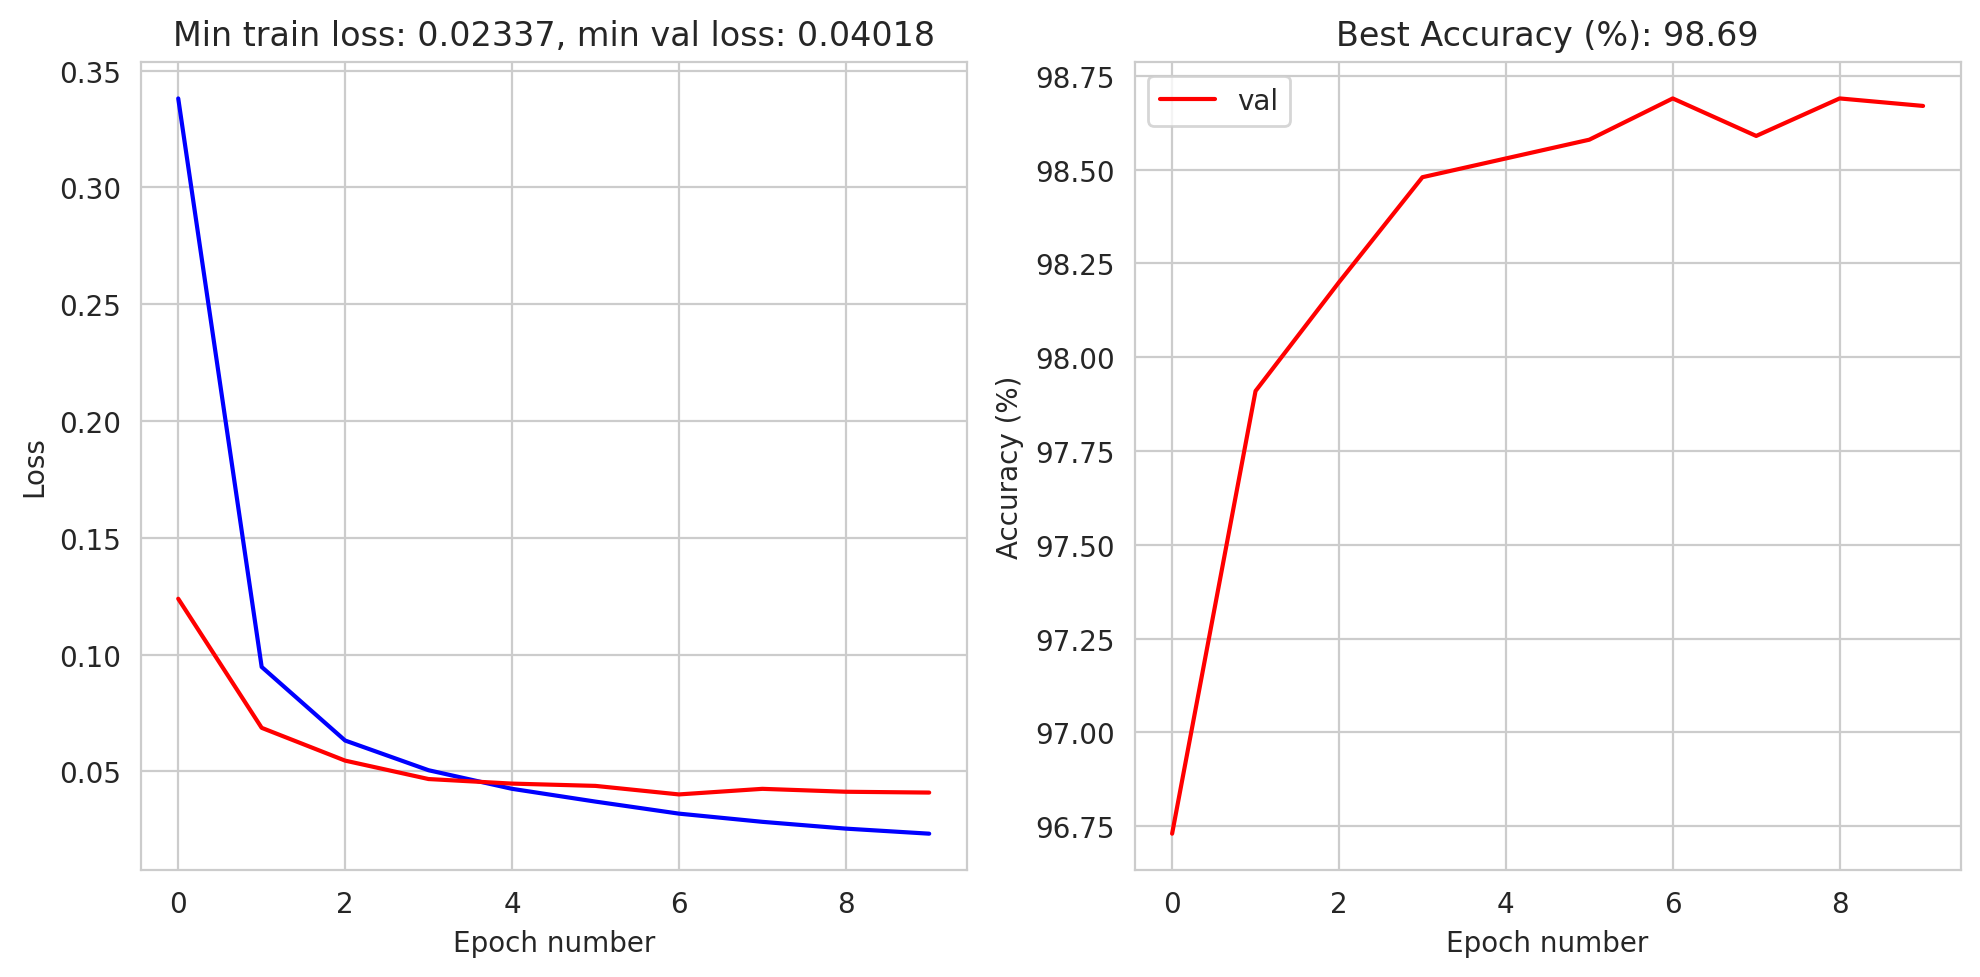

In [136]:
train(conv_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

In [137]:
# Res net

# do not forget to put the model itself on device
res_net = ResNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
res_net.to(device)

optimizer = torch.optim.Adam(res_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

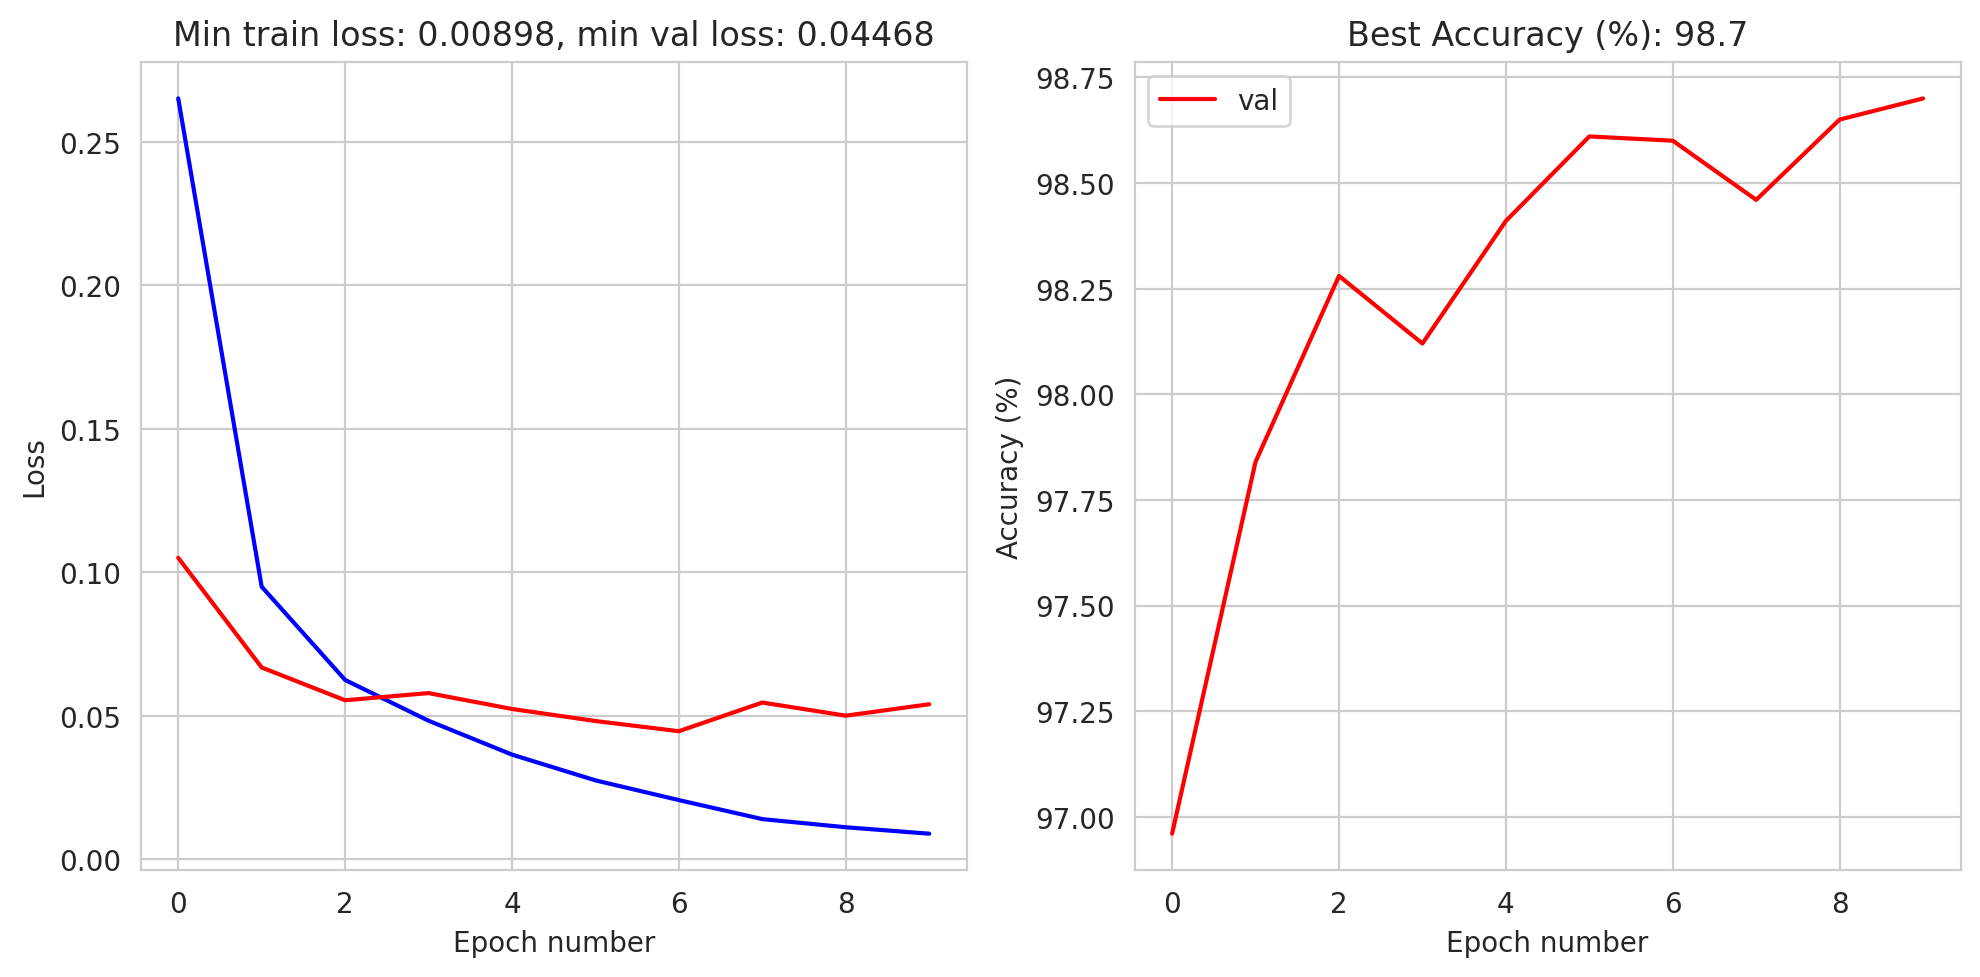

In [138]:
train(res_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

**Important** loss value usually does not represent the actual quality of the model. You should look at some metrics, like accuracy.